With the last blog entry about GANs we got everything we can out of the MNIST dataset, so this time we try something completely different. I have long been fascinated by videos where an AI is trained to play through a level of a video game, for example Super Mario, so with this blog post I want to show a small example of reinforcement learning.

Reinforcement Learning is a type of machine learning where an agent learns how to behave in an environment by performing certain actions and receiving rewards or penalties in return. It's a bit like training a dog: the dog is the agent, the environment is the place where the dog can perform tricks, and the treats (or lack thereof) are the rewards or penalties. In RL, the agent makes a series of decisions (or actions), and after each decision, it gets a reward (which can be positive, negative, or zero). The goal of the agent is to learn a strategy (or policy) that will maximize its expected reward over time.

I have chosen Tic Tac Toe for this, because it is a simple board game with clear rules and a finite number of states and actions. This makes it an excellent beginner example for RL. The game is deterministic, meaning there's no luck or randomness involved in the game's outcome, aside from the initial decision of who goes first.

In the context of RL, we then have the following terms:
- State: The current configuration of the Tic-Tac-Toe board.
- Action: Placing a mark (either 'X' or 'O') on an empty spot on the board.
- Reward: Received after making a move. For instance, a positive reward for winning, a negative reward for losing, and no reward for drawing.

The difference to video games like Super Mario here, however, is that the AI learns by playing against itself instead of enemies or hazards. 

The approximate flow of the AI therefore looks something like this:
1. When the agent starts, it knows nothing about the game. Its actions are essentially random because its knowledge (Q-values) is initialized arbitrarily (often to zero or small random values).
2. Even in this randomness, there are moments of accidental success or failure. For instance, the agent might, by chance, make a series of moves that lead to a win. It receives a positive reward for this. Conversely, it might make a blunder that leads to a loss and gets a negative reward. Over many episodes, these random successes and failures start to inform the agent about which actions are generally more promising than others.
3. As the agent continues to play, it starts to build a rudimentary strategy based on the rewards it has received. It will start to favor actions that have previously led to positive outcomes. This strategy is far from perfect, but it's better than random. When the agent plays using this strategy, it gets new data - new wins and losses that help refine the strategy further. When the agent plays against itself, both the "player" and "opponent" roles are guided by the same strategy, as the "player" role learns and improves, the "opponent" role does too.

Let's start by inspecting the code for the Tic Tac Toe game.
First the "board" for the game is created, this happens in the initialization (**__init__**)
*self.board*: Initializes the game board as a 3x3 matrix filled with zeros (indicating empty cells).
*self.current_player*: Initializes the current player as 1. (Player 1 will be 'X' and Player 2 will be 'O')

**available_moves** has only one line but I will break it down a bit:
*self.board == 0* creates a boolean matrix of the same shape as *self.board*. Each element in this matrix is *True* if the corresponding cell in *self.board* is 0 (indicating it's empty and a move can be done here) and *False* otherwise.
*np.where* applied to this boolean matrix returns two separate arrays: one for the row indices and one for the column indices where the condition (i.e., the cell being 0) is True.

Suppose our board looks like this:
    [[1, 0, 2],
     [0, 1, 0],
     [2, 0, 0]]
 
Applying *self.board == 0* would yield:
    [[False, True, False],
     [True, False, True],
     [False, True, True]]
 
And *np.where(self.board == 0)* would return two arrays:
Row indices: [0, 1, 1, 2, 2]
Column indices: [1, 0, 2, 1, 2]

These arrays indicate that empty spots are at positions (0,1), (1,0), (1,2), (2,1) and (2,2) on the board.
*zip(*np.where(self.board == 0))*: The * operator is used to unpack the arrays returned by *np.where* as *zip* expects its arguments to be separate sequences (like lists or arrays). If you pass the tuple directly to *zip*, it would treat the entire tuple as one sequence. That's not what we want. By using the * operator before the tuple, we're essentially telling Python to treat the individual arrays inside the tuple as separate arguments to the function. *zip* then pairs the corresponding elements of these arrays together, effectively producing coordinates of the empty spots.

Using the same example, after the *zip* function, we'd get:
    [(0,1), (1,0), (1,2), (2,1), (2,2)]

Then *list(...)* converts the zipped object into a list.

Next is **make_move**: The input move is a tuple (i, j) representing the position (row i, column j) where the current player wants to place their mark. *if self.board[move] == 0:* checks if the cell at position *move* on the board is empty (has a value of 0). If the chosen cell is empty, the current player's mark is placed on the board at that position. The mark is represented by the player's number (1 for Player 1 and 2 for Player 2). In the next if-condition **check_win** is used, which I will explain later in more detail. Basically the method then checks if this move resulted in a win using the *check_win* function. If the current player has won:
- Player 1 (represented by 1) receives a reward of 10.
- Player 2 (represented by 2) receives a reward of -10.

Afterwards we also check with *if len(self.available_moves()) == 0* for a draw, as that is a possible outcome in Tic-Tac-Toe As well. If nobody has won yet and there are no available moves left, it means the game has ended in a draw. In this case, a reward of 0 is returned.
Next we switch the current player to the other player. As we only have two players and the players have the numbers 1 and 2 assigned, we can simply use *self.current_player = 3 - self.current_player* to switch the players. Then, a reward of 0 is returned, indicating the game continues without any decisive outcome from the current move.
Lastly the agent has to learn, that there are also invalid moves: If the initial check found that the chosen cell is not empty (i.e., it already has a mark), then the move is invalid. In this case:
- Player 1 (represented by 1) receives a penalty of -10.
- Player 2 (represented by 2) receives a penalty of 10.

As already mentioned before, we need **check_win** to determine if the current player has won. 
The method starts by iterating through each row and column index ii from 0 to 2. 
*np.all(self.board[i, :] == self.current_player)* checks if all elements in the *i*th row are equal to the current player's mark. This would mean that the current player has all their marks in a horizontal line on the board. 
*np.all(self.board[:, i] == self.current_player)* checks if all elements in the *i*th column are equal to the current player's mark, indicating a vertical line of the current player's marks. If either of these conditions is true for any row or column, the method immediately returns True, indicating a win for the current player. The following two *if* statements check for a win along the two possible diagonals of the 3x3 board. The first *if* statement checks the main diagonal, from the top-left to the bottom-right. If all cells in this diagonal have the current player's mark, it's a win. The second *if* statement checks the other diagonal, from the top-right to the bottom-left. Again, if all cells in this diagonal contain the current player's mark, it's a win. If either diagonal condition is met, the method returns *True*. If none of the above checks for rows, columns, or diagonals find a winning configuration, the method concludes there's no win for the current player and returns *False*. The last function **reset** is used to reset the board for the next training loop.

In [1]:
import numpy as np

class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1

    def available_moves(self):
        return list(zip(*np.where(self.board == 0)))

    def make_move(self, move):
        if self.board[move] == 0:
            self.board[move] = self.current_player
            if self.check_win():
                return 10 if self.current_player == 1 else -10
            if len(self.available_moves()) == 0:
                return 0
            self.current_player = 3 - self.current_player
            return 0
        else:
            return -10 if self.current_player == 1 else 10

    def check_win(self):
        for i in range(3):
            if np.all(self.board[i, :] == self.current_player) or np.all(self.board[:, i] == self.current_player):
                return True
        if self.board[0, 0] == self.current_player and self.board[1, 1] == self.current_player and self.board[
            2, 2] == self.current_player:
            return True
        if self.board[0, 2] == self.current_player and self.board[1, 1] == self.current_player and self.board[
            2, 0] == self.current_player:
            return True
        return False

    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1

The next part is the Q-Network, which is a model-free algorithm, basically a trial-and-error method. "Q" refers to the function that the algorithm computes – the expected rewards for an action taken in a given state. I did not find a deeper meaning to the letter "Q", it probably was just standardized for the mathematical notation of the network. The *QNetwork* class is a simple neural network architecture implemented using PyTorch's *nn.Module*. It consists of three fully connected (or linear) layers. For a simple problem like Tic-Tac-Toe, a straightforward neural network architecture with linear layers might suffice. More complex problems (like playing Super Mario) might require convolutional layers or recurrent layers. The choice of 128 neurons for the hidden layers is somewhat arbitrary, but should be sufficient for Tic-Tac-Toe and well and ReLu is always a good choice for the activation functions in a feedforward neural network. In *__init__*, we initialize the layers and its sizes. *super(QNetwork, self).__init__()* calls the initialization method of the parent class (*nn.Module*), ensuring the network is set up correctly. As someone coming from MATLAB *super* and *__init__* are not exactly intuitive, so here is a little excursion if anyone else has it's problems with it:
In Python, super() is used to call a method from a parent class. Here the *QNetwork* class is inheriting from *nn.Module*, which is a base class provided by PyTorch for all neural network modules. This base class comes with many built-in functionalities that are useful for neural networks. When we create an instance of the *QNetwork* class, we want to make sure that the initialization process of the parent class (*nn.Module*) is also executed. The *super(QNetwork, self).__init__()* line is calling the *__init__* method of the *nn.Module* class, ensuring that the initialization of the parent class is done. Back to our code: we have three fully connected layers, transforming from the 9 initial possible actions, to 128 and in the last layer back to 9, as we need 9 Q-values. When deciding on an action, the agent will typically choose the action corresponding to the highest Q-value. The *forward* method defines the structure of the network, where the layers are simply connected by ReLu functions and it returns the raw Q-values in the last layer.
Why do we want raw Q-values? 
Raw Q-values are the neural network's estimates of the expected future rewards for each action. Having raw, unbounded Q-values makes it straightforward to calculate the loss and to find the maximum value and its corresponding action. 

In [2]:
import torch.nn as nn

class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(9, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 9)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        return self.fc3(x)

**train_q_network** contains the training loop for our agent. For the exploration we use a classic RL method, the epsilon-greedy method (see multi-armed bandit on Wikipedia). This method balances exploration and exploitation. Exploration means, the agent tries different actions to discover their effects, hoping to find optimal actions and exploitation means, the agent chooses the action that it currently believes to have the highest expected reward. So, in this strategy:
- With probability ϵ, the agent chooses an action uniformly at random (exploration).
- With probability 1−ϵ, the agent chooses the best action according to its current knowledge (exploitation).

We also have the ϵ-decay, because over time, as the agent learns more about the environment, it makes sense to reduce the amount of random exploration and rely more on the learned strategy (policy). While decreasing ϵ we don't want it to go to zero. Having a small amount of exploration can be beneficial even in the later stages of training. We let it loop for 3000 episodes, each episode corresponds to playing one game of Tic-Tac-Toe. With the start of each episode, the board is reset, the current state of the board is flattened into a 1D array (so that it can be used for the neural network) and *episode_reward* is initialized to 0. The agent uses an epsilon-greedy strategy to select actions:
- With probability ϵ, choose a random action (using *random.choice*).
- Otherwise, use the QNetwork to estimate the Q-values for the current state and choose the action with the highest Q-value.

A bit more detail on the last part: If the agent doesn't decide to explore (i.e., the random number is greater than or equal to ϵ), it will exploit its current knowledge. First the current state of the game is passed through the QNetwork to obtain the estimated Q-values for each possible action and the available moves on the current board are fetched. The line *available_action_indices = ...* converts the 2D action coordinates from the 3x3 Tic-Tac-Toe board into a corresponding index in the flattened 1D state representation. For example, if an action is to place a mark in the second row and third column (action = (1, 2)), its index in the flattened state is 5. The following *action = ...* line selects the action with the highest Q-value from among the available actions. *torch.argmax()* returns the index of the maximum value in the *action_values* tensor for the available actions, and *.item()* converts the tensor value to a Python scalar. Finally, this index is used to fetch the corresponding action from the *available_actions* list.

Afterwards the agent takes action: The chosen action is executed in the game, and the resulting reward is recorded. If the game has ended (e.g., someone won or it's a draw), the game loop is exited. Otherwise, the state is updated for the next iteration and after each episode, ϵ is decayed to reduce the probability of random actions over time. Then the results of each episode (win, draw, or loss) are tracked for later visualization. Every 100 episodes, the rates of wins, draws, and losses are appended and then reset.

In [3]:
import torch
import random

def train_q_network(game, network, num_episodes=3000):
    epsilon = 0.9
    epsilon_decay = 0.995
    min_epsilon = 0.05
    rewards = []

    win_rates = []
    draw_rates = []
    loss_rates = []
    wins = 0
    draws = 0
    losses = 0

    for episode in range(num_episodes):
        game.reset()
        state = game.board.flatten()
        episode_reward = 0
        while True:
            if random.random() < epsilon and game.available_moves():
                action = random.choice(game.available_moves())
            else:
                action_values = network(torch.tensor(state, dtype=torch.float32))
                available_actions = game.available_moves()
                if not available_actions:
                    break
                available_action_indices = [3*action[0] + action[1] for action in available_actions]
                action = available_actions[torch.argmax(action_values[available_action_indices]).item()]
            reward = game.make_move(action)
            episode_reward += reward
            if reward != 0:
                break
            state = game.board.flatten()
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards.append(episode_reward)

        if episode_reward == 10:
            wins += 1
        elif episode_reward == 0:
            draws += 1
        else:
            losses += 1

        if (episode + 1) % 100 == 0:
            win_rates.append(wins / 100)
            draw_rates.append(draws / 100)
            loss_rates.append(losses / 100)
            wins, draws, losses = 0, 0, 0
    return rewards, win_rates, draw_rates, loss_rates

This was the training part, the remaining code is for the visualization of the training process and the results. The first loop draws the two vertical and two horizontal lines that make up the Tic-Tac-Toe grid. The nested loop goes through each cell of the Tic-Tac-Toe board; if a cell contains a 1, it draws an 'X' using two straight lines, if a cell contains a 2, it draws an 'O' using the *plt.Circle()* function. If the *winning_line* argument is provided, the last block draws a red line ('r-') to highlight the winning row, column, or diagonal.

In [4]:
import matplotlib.pyplot as plt

def draw_board(board, winning_line=None):
    plt.gca().clear()
    # Drawing the board
    for i in range(1, 3):
        plt.plot([i, i], [0, 3], 'k-', lw=2)
        plt.plot([0, 3], [i, i], 'k-', lw=2)

    for i in range(3):
        for j in range(3):
            if board[i, j] == 1:
                plt.plot([j, j + 1], [3 - i, 2 - i], 'k-', lw=2)
                plt.plot([j + 1, j], [3 - i, 2 - i], 'k-', lw=2)
            if board[i, j] == 2:
                circle = plt.Circle((j + 0.5, 2.5 - i), 0.4, color='k', fill=False, lw=2)
                plt.gca().add_patch(circle)

    if winning_line:
        plt.plot(winning_line[0], winning_line[1], 'r-', lw=3)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, 3)
    plt.ylim(0, 3)
    plt.show(block=False)
    plt.pause(0.5)
    plt.clf()

The *visualize_game* function is designed to visually simulate a game of Tic-Tac-Toe where one player (Player 1) is controlled by the trained neural network (the QNetwork) and the other player (Player 2) selects its moves randomly. This function provides a way to observe the behavior of the trained agent in a game setting.

In [5]:
def visualize_game(game, network):
    game.reset()
    draw_board(game.board)
    while True:
        available_moves = game.available_moves()
        if len(available_moves) == 0:
            print("It's a draw!")
            break
        if game.current_player == 1:
            action_values = network(torch.tensor(game.board.flatten(), dtype=torch.float32))
            available_action_indices = [3 * action[0] + action[1] for action in available_moves]
            action = available_moves[torch.argmax(action_values[available_action_indices]).item()]
            game.make_move(action)
            if game.check_win():
                draw_board(game.board, get_winning_line(game.board))
                print("Player 1 (X) wins!")
                break
            else:
                draw_board(game.board)
        else:
            action = random.choice(available_moves)
            game.make_move(action)
            if game.check_win():
                draw_board(game.board, get_winning_line(game.board))
                print("Player 2 (O) wins!")
                break
            else:
                draw_board(game.board)

The next function *get_winning_line* is used to determine the winning line, if there is one. The function loops through all the rows of the board. For each row *i*, it checks if all elements in that row are 1 (X's) or 2 (O's). If either condition is true, it means that there's a horizontal winning line. The function then returns the starting and ending coordinates for this horizontal line. The 2.5 - i logic converts the row index i to the y-coordinate for drawing the line. The 0.5 and 2.5 values are used to get the center coordinates of the columns and rows, respectively. In the end it also checks for diagonal winning lines.

In [6]:
def get_winning_line(board):
    for i in range(3):
        if np.all(board[i, :] == 1) or np.all(board[i, :] == 2):
            return [[0, 3], [2.5 - i, 2.5 - i]]
        if np.all(board[:, i] == 1) or np.all(board[:, i] == 2):
            return [[0.5 + i, 0.5 + i], [0, 3]]
    if board[0, 0] == board[1, 1] == board[2, 2] != 0:
        return [[0, 3], [3, 0]]
    if board[0, 2] == board[1, 1] == board[2, 0] != 0:
        return [[3, 0], [3, 0]]
    return None

The following function visualizes various metrics: the rewards obtained over episodes and the win, draw, and loss rates computed every 100 episodes. I also wanted smoothed lines in both plots, so we use a gaussian filter for that, where the sigma parameter controls the degree of smoothing. This smoothed curve helps in visualizing the general trend in rewards over episodes and the win, loss and draw rates.

In [7]:
from scipy.ndimage import gaussian_filter1d
 
def plot_metrics(rewards, win_rates, draw_rates, loss_rates):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(range(len(rewards)), rewards, label='Reward per Episode', marker='o', alpha=0.2)
    plt.plot(gaussian_filter1d(rewards, sigma=20), color='blue')
    plt.title('Rewards over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')

    episodes = [i * 100 for i in range(len(win_rates))]
    plt.subplot(1, 2, 2)
    plt.scatter(episodes, win_rates, label='Win Rate', marker='o', alpha=0.2, color='blue')
    plt.scatter(episodes, draw_rates, label='Draw Rate', marker='o', alpha=0.2, color='orange')
    plt.scatter(episodes, loss_rates, label='Loss Rate', marker='o', alpha=0.2, color='green')

    plt.plot(episodes, gaussian_filter1d(win_rates, sigma=2), color='blue')
    plt.plot(episodes, gaussian_filter1d(draw_rates, sigma=2), color='orange')
    plt.plot(episodes, gaussian_filter1d(loss_rates, sigma=2), color='green')

    plt.title('Win, Draw, and Loss Rates')
    plt.xlabel('Every 100 Episodes')
    plt.ylabel('Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

Now we just have to initialize the game and the network and start the training.

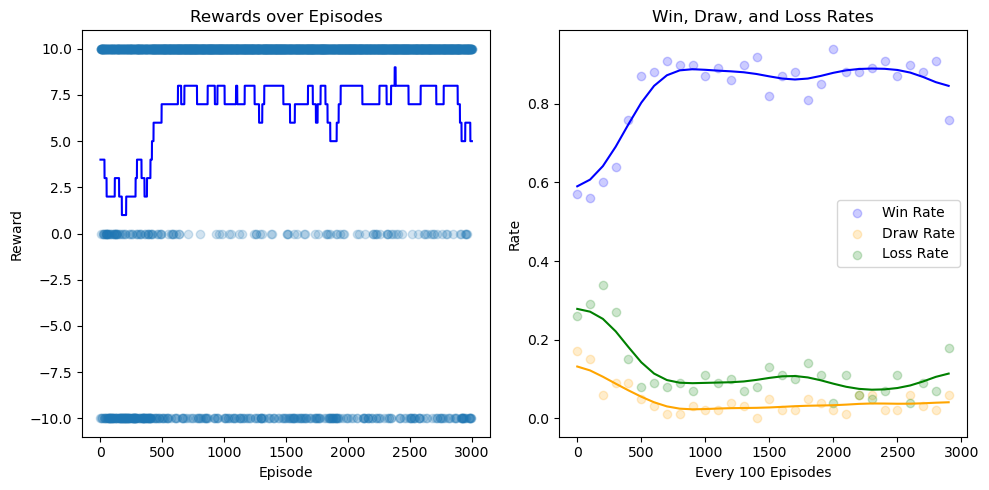

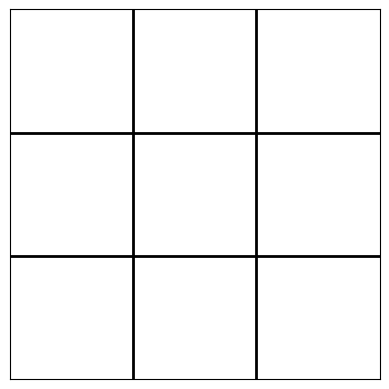

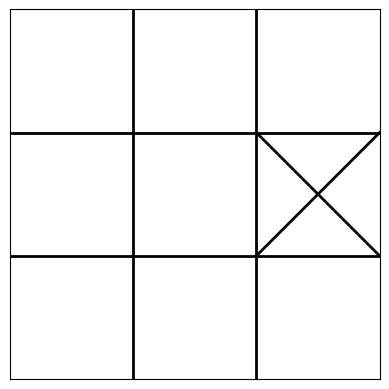

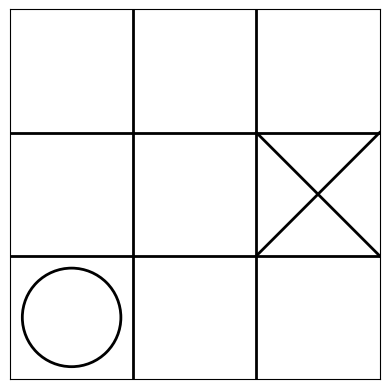

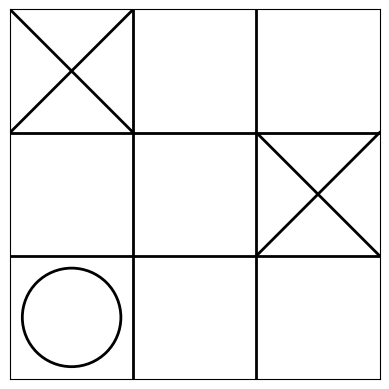

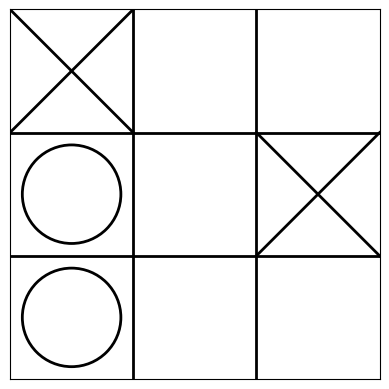

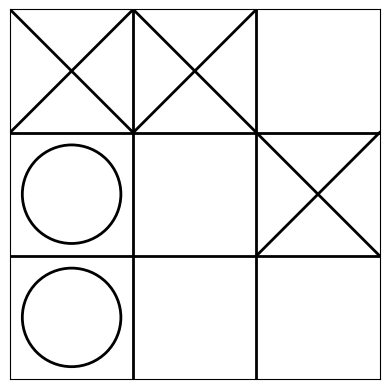

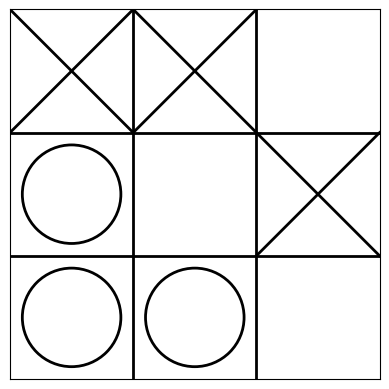

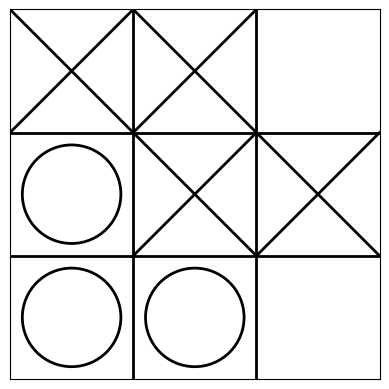

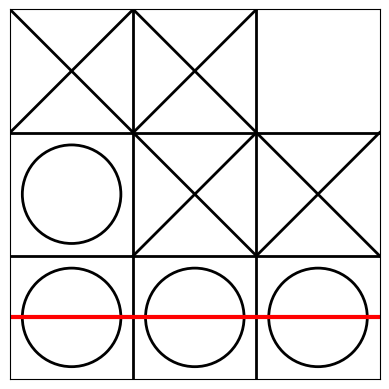

Player 2 (O) wins!


<Figure size 640x480 with 0 Axes>

In [8]:
game = TicTacToe()
network = QNetwork()
rewards, win_rates, draw_rates, loss_rates = train_q_network(game, network)
plot_metrics(rewards, win_rates, draw_rates, loss_rates)
plt.figure()
visualize_game(game, network)

Now we can see the following plots: the win, loss and draw rates, the rewards over episodes rewards with (both the with smoothed averages) and an example game. We can see that the win rate starts somewhere between 0.4 and 0.6 and converges to above 0.8, a nice result for this simple network! The rewards over episodes shows that the agent is initially exploring the environment and doesn't yet know how to act optimally. As a result, the reward averages to about 2.5. Latere it converges to around 7.5, which means that the agent is winning most of its games, occasionally drawing, and rarely losing (as seen in the example game). I think to get closer to 100% win rate, the network would need to be more complex, but this is still a nice result, considering the size of the network.